In [11]:
%load_ext autoreload
%autoreload 2
from glob import glob
import os
import re
import sys
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from func.utils import get_categorical_features, read_pkl_gzip, to_pkl_gzip, parallel_load_data, get_filename
from func.time_utils import date_add_days

%matplotlib inline
sns.set(style='whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
train_target = read_pkl_gzip('../submit/re_sub/isFraud_train.gz')
test_target = read_pkl_gzip('../submit/re_sub/isFraud_test.gz')
# all_pred = read_pkl_gzip('../output/pred_result/20191003_2025__CV0-9261293240975311__all_preds.gz').iloc[:, 1].values
new_pred = read_pkl_gzip('../output/pred_result/20191003_2120__CV0-9232580564381806__all_preds.gz').iloc[:, 1].values
vc_pred = read_pkl_gzip('../output/pred_result/20191003_2158__CV0-9315591266085672__all_preds.gz').iloc[:, 1].values
fi_pred = read_pkl_gzip('../output/pred_result/20191003_2158__CV0-9315591266085672__all_preds.gz').iloc[:, 1].values
train_pred = all_pred[:len(train_target)]
train_pred = all_pred[len(train_target):]

In [9]:
COLUMN_ID = 'TransactionID'
COLUMN_DT = 'TransactionDT'
COLUMN_TARGET = 'isFraud'
COLUMNS_IGNORE = [COLUMN_ID, COLUMN_DT, COLUMN_TARGET, 'ProductCD']

train_paths = glob('../feature/eda_base/*_train.gz')
test_paths  = glob('../feature/eda_base/*_test.gz')

train_paths = [path for path in train_paths 
               if (path.count(COLUMN_DT) 
               or path.count(COLUMN_ID)
               or path.count(COLUMN_TARGET)
               or path.count('D1')
               )
               and not path.count('fill')
               and not path.count('bin')
               and not path.count('129')
              ]
test_paths = [path for path in test_paths 
               if (path.count(COLUMN_DT) 
               or path.count(COLUMN_ID)
               or path.count(COLUMN_TARGET)
               or path.count('D1')
               )
               and not path.count('fill')
               and not path.count('bin')
               and not path.count('129')
              ]

df_train = parallel_load_data(train_paths)
df_test = parallel_load_data(test_paths)
data = pd.concat([df_train, df_test], axis=0, ignore_index=True)
train_length = df_train.shape[0]

In [12]:
START_DATE = '2017-12-01'
# START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')

data['datetime'] = data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x) - datetime.timedelta(seconds = 14400) ))
data['datetime'].fillna(datetime.date(2020, 1, 1), inplace=True)
data['date'] = data['datetime'].map(lambda x: x.date())

list_regist = []
for d, diff in tqdm(data[['date', 'D1']].values):
    if diff < 999999:
        regist = date_add_days(d, -1*diff)
    else:
        regist = date_add_days(d, 0)
    list_regist.append(str(regist))

data['Regist_date'] = list_regist

100%|██████████| 1097231/1097231 [00:04<00:00, 240630.28it/s]


In [86]:
data['pred'] = all_pred
data['new'] = new_pred
data['v_c'] = vc_pred

In [87]:
tmp = data.groupby('date')[['pred', COLUMN_TARGET, 'new', 'v_c']].agg({ 'mean', 'mean' })
tmp.columns = ['pred_mean', 'Fraud_mean', 'new_mean', 'v_c_mean']

v1 = tmp['pred_mean'].reset_index()
v2 = tmp['Fraud_mean'].reset_index()
v3 = tmp['new_mean'].reset_index()
v4 = tmp['v_c_mean'].reset_index()

v1.columns = ['date', 'val']
v2.columns = ['date', 'val']
v3.columns = ['date', 'val']
v4.columns = ['date', 'val']
v1['dtype'] = 'device_&_D'
v2['dtype'] = 'true'
v3['dtype'] = 'D_only'
v4['dtype'] = 'V_C'

In [98]:
# haku_oof = pd.read_csv('../output/oof.csv')
# haku_pred = pd.read_csv('../output/submission.csv')
# haku_oof.columns = [COLUMN_ID, COLUMN_TARGET]
# haku_pred.columns = [COLUMN_ID, COLUMN_TARGET]
# haku_oof['date']  = data.iloc[:train_length]['date'].values
# haku_pred['date'] = data.iloc[train_length:]['date'].values

holy = pd.read_csv('../output/final_no_D_agg__holygo__pred__CV0.957552.csv')
holy['date'] = data.iloc[train_length:]['date'].values

haku = pd.concat([haku_oof, haku_pred], axis=0)
haku_agg = haku.groupby('date')[COLUMN_TARGET].agg({ 'mean', 'mean' }).reset_index()
haku_agg.columns = ['date', 'val']
haku_agg['dtype'] = 'haku'

holy_agg = holy.groupby('date')[COLUMN_TARGET].agg({ 'mean', 'mean' }).reset_index()
holy_agg.columns = ['date', 'val']
holy_agg['dtype'] = 'holy'


holy2 = pd.read_csv('../submit/lb/20191003__CV0.959106.csv')
holy2['date'] = data.iloc[train_length:]['date'].values
holy2_agg = holy2.groupby('date')[COLUMN_TARGET].agg({ 'mean', 'mean' }).reset_index()
holy2_agg.columns = ['date', 'val']
holy2_agg['dtype'] = 'holy2'

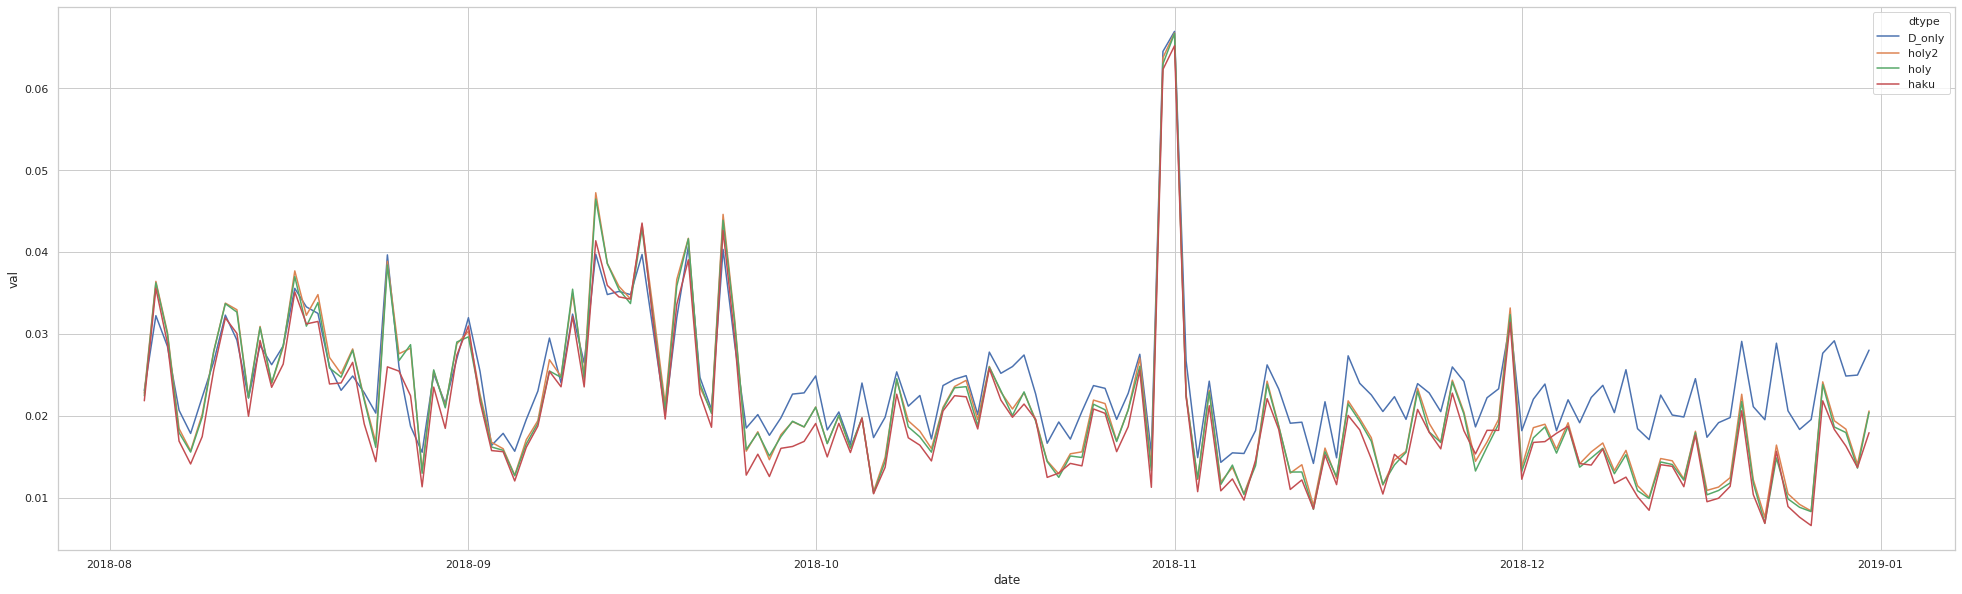

In [101]:
plt.figure(figsize=(34, 10))
# result = pd.concat([v1, v2, haku_agg, v3, v4], axis=0)
result = pd.concat([holy_agg, holy2_agg, haku_agg, v3], axis=0).sort_values(by='date').tail(600)
sns.lineplot(data=result, x='date', y='val', hue='dtype', legend='full')
# sns.lineplot(data=v1, x='date', y='val')
# sns.lineplot(data=v2, x='date', y='val')
# sns.lineplot(data=haku_agg, x='date', y='val')
# sns.lineplot(data=v3, x='date', y='val')
plt.show()

In [ ]:
D系user_id_agg
Fold  Valid    oof                
Fold0 2017-12: 0.883013523183629  | Bear's...PB:0.9782110 PV:0.9663108
Fold1 2018-3 : 0.9333383828640867 | Bear's...PB:0.9677055 PV:0.9593918
Fold2 2018-1 : 0.93161347814986   | Bear's...PB:0.9694335 PV:0.9596462
Fold3 2018-5 : 0.9279721690326594 | Bear's...PB:0.9308613 PV:0.9122155
Fold4 2018-2 : 0.9403527289606672 | Bear's...PB:0.9531799 PV:0.9466264
CV: 0.9232580

V, C系user_id_agg
Fold0 2017-12: 0.901948163188613  | Bear's...PB:0.9428371 PV:0.9497358
Fold1 2018-3 : 0.9395659415256739 | Bear's...PB:0.9609112 PV:0.9589212
Fold2 2018-1 : 0.9395701120905666 | Bear's...PB:0.9569850 PV:0.9612100
Fold3 2018-5 : 0.9289755579611828 | Bear's...PB:0.9121352 PV:0.9137780
Fold4 2018-2 : 0.947735858276799  | Bear's...PB:0.9434475 PV:0.9406963
CV: 0.9315591